In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 26/11/2021

    Code description :
    __________________
    Generates sparse object and recover it 
    by solving an inverse problem from rank-one projections.
    We use SPGL1 which is faster in 1D.

"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers, acceleration
from pyunlocbox.functions import _soft_threshold
import time
import pywt
import spgl1
import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from functions import snr, corr_circ

We obtained the following observation model :

\begin{equation*}
    \boldsymbol{y} = \left\{ y \right\}_{m=1}^M = \left\{ \boldsymbol{\beta}_m^* \boldsymbol{J \beta}_m \right\}_{m=1}^M
\end{equation*}

with: 
\begin{equation*}
    J_{ll^{'}} = \int_{\mathcal{D}} \phi_l (x)
    \phi_{l^{'}}^* (x) f(x) dx = \frac{1}{2 \pi} \int_{\mathcal{D}} 
    e^{i 2\pi (l-l') x} f(x) dx
\end{equation*}

a circulant matrix. <br>

We have also seen that : 
\begin{equation*}
    \langle \boldsymbol{B},T(\boldsymbol{u}) \rangle_{\mathbb{C}^{N\times N}} = 
    \langle T^*(\boldsymbol{B}), \boldsymbol{u} \rangle_{\mathbb{C}^N} = \left( \boldsymbol{\beta} * \overline{\boldsymbol{\beta}} \right)^T \boldsymbol{u}
\end{equation*}

Where $\boldsymbol{B}= \boldsymbol{\beta\beta}^*$ is a rank-one matrix serving as projector for the ROPs, $\overline{\boldsymbol{\beta}}$ is the flipped version of $\boldsymbol{\beta}$ ($\beta_{j}=\overline{\beta}_{-j}$) and $\boldsymbol{u}$ is the vector generating the circulant matrix $T(\boldsymbol{u})$, here its first column. <br>

We end up with: 
\begin{equation*}
    \begin{array}{ll}
    \boldsymbol{y} &= \left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m)^T \boldsymbol{F f} \right\}_{m=1}^M + \boldsymbol{n} \\
    &= \boldsymbol{\Beta Ff} + \boldsymbol{n}
    \end{array} 
\end{equation*}

where $*$ is the convolution operator, $\Beta$ is a $M \times N$ matrix whose lines are $\left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m) \right\}_{m=1}^M$ and $\boldsymbol{F}$ is the linear operator applying 1D Fourier transform. <br>

We consider the following inverse problem for a sparse 1D object $\boldsymbol{f}$: 
\begin{equation*}
    \hat{\boldsymbol{f}} = \text{argmin}_{\boldsymbol{f}}~\frac{1}{2} \lVert
    \boldsymbol{\Beta Ff} - \boldsymbol{y} \rVert_2^2 + \lambda \lVert \boldsymbol{f} \rVert_1
\end{equation*}

The vector $\boldsymbol{\beta}$ is given by: 
\begin{equation*}
    \boldsymbol{\beta} = 
    \sum_{k=1}^Q \alpha_k \boldsymbol{e}_{p_k}
\end{equation*}

where $\boldsymbol{\alpha} \in \mathbb{C}^Q$ contains the complex amplitudes of the light emitted by each of the $Q$ cores, and $\boldsymbol{e}_{p_k}$ is the index position of core $k$ in the 1D space. The complex amplitudes are i.i.d as $\alpha_{ij} \sim \mathcal{N}(0,1)$ <br>

 **Note**: choosing $M \approx s \log(\frac{eN}{s})$ is sufficient!

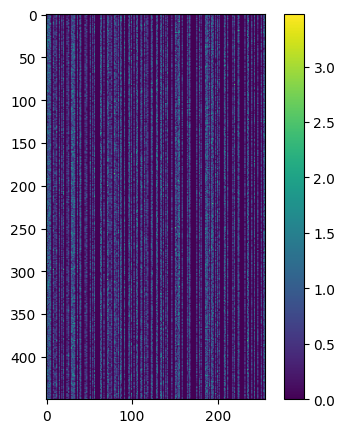

In [2]:
N = 256 # vector size
K = 50 # sparsity
Q = 100 # Number of cores
M = 450 # Number of observations y

"Define the sparse object"
f = np.zeros(N)
f[np.random.permutation(np.arange(N))[:K]] = (-1)**(np.arange(K))

# F = T(f) #Fourier transform

" Suggestion LJ "
# for i in range(M):
#     beta[i,np.random.permutation(np.arange(0,N))[:Q]] = a_ij[i,:]
" From analytical developments, beware of the np.conj!!"
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)
pos_cores = np.random.permutation(np.arange(N))[:Q] # random cores locations
# pos_cores = np.round(np.arange(Q)*(N-1)/(Q-1)).astype(int) # regularly spaced cores locations
beta = np.zeros((M,N), dtype=complex)
beta[:, pos_cores] = a_ij
beta2 = corr_circ(beta.conj()) # autocorrelations of beta

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om = np.subtract.outer(pos_cores, pos_cores).astype(int)
"Compute the multiplicity of each frequency"
multiplicities = ind_multiplicity_1D(Om)
"Compute the interferometric matrix"
IntM = S_Om_1D(T(f), Om, mult_mat=multiplicities)

"Plot"
plt.figure(figsize=(5,5))
plt.imshow(np.abs(beta), cmap='viridis')
plt.colorbar()
plt.show()

SNR_target = 100
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol, verbosity=0)[0]
bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma, opt_tol=opt_tol)[0]
lasso = lambda A, b, tau: spgl1.spg_lasso(A, b, tau, opt_tol=opt_tol)[0]

The SNR is defined as:
$
    SNR = 20 \log \left( \frac{\lVert f \rVert_2}{\lVert f - \hat{f} \rVert_2} \right)
$

We thus target an error of:
$
    \lVert f - \hat{f} \rVert_2 = \lVert f \rVert_2 ~10^{SNR/20}
$

Where the SNR value can be changed.

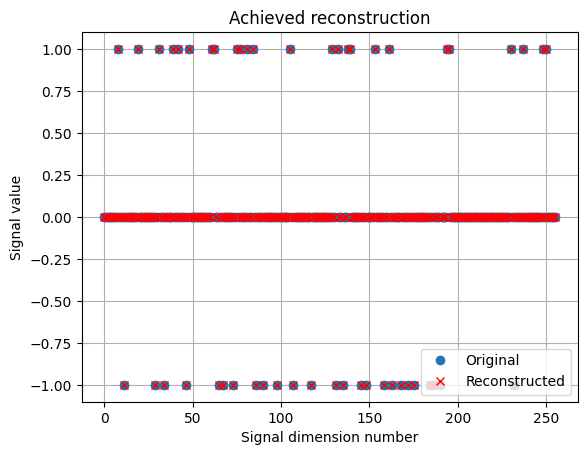

SNR: 111.24 dB
SNR: 112.64 dB
SNR: 77.29 dB


In [3]:
A_corr = Autocorr_model(beta2)
A_corr_r = Op2Real(A_corr)
y_corr_r = A_corr_r@f
x_corr = bpalg(A_corr_r, y_corr_r)
x_corr2 = bpdnalg(A_corr_r, y_corr_r,1e-10)
x_corr_lasso = lasso(A_corr_r, y_corr_r, tau=K)

plt.figure()
plt.plot(f, 'o', label='Original')
plt.plot(x_corr, 'xr', label='Reconstructed')
plt.grid(True)
plt.title('Achieved reconstruction')
plt.legend(numpoints=1)
plt.xlabel('Signal dimension number')
plt.ylabel('Signal value')
plt.show()

print('SNR: {:.2f} dB'.format(snr(f, x_corr)) )
print('SNR: {:.2f} dB'.format(snr(f, x_corr2)) )
print('SNR: {:.2f} dB'.format(snr(f, x_corr_lasso)) )

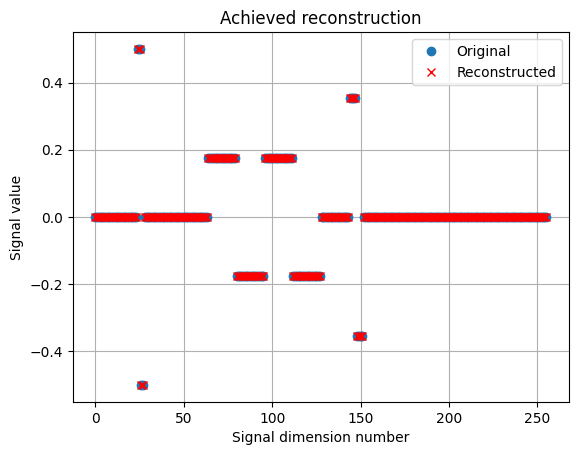

SNR: 104.79 dB


In [4]:
toy_coeffs = np.zeros(N)
toy_coeffs[10:12] = 1
toy_coeffs[50] = 1
toy_coeffs[70] = 1

A_corr_wt = Autocorr_model(beta2, wt='haar')
A_corr_wt_r = Op2Real(A_corr_wt)
y_corr_r = A_corr_wt_r@toy_coeffs
x_corr = bpalg(A_corr_wt_r, y_corr_r)

f_wav = A_corr_wt.wavT(toy_coeffs)
f_hat = A_corr_wt.wavT(x_corr)

plt.figure()
plt.plot(f_wav, 'o', label='Original')
plt.plot(f_hat, 'xr', label='Reconstructed')
plt.grid(True)
plt.title('Achieved reconstruction')
plt.legend(numpoints=1)
plt.xlabel('Signal dimension number')
plt.ylabel('Signal value')
plt.show()

print('SNR: {:.2f} dB'.format(snr(f_wav, f_hat)) )

(K,M, trial) = (4,120,0)
53.50851257944906
(K,M, trial) = (4,120,1)
60.07136271851004
(K,M, trial) = (4,120,2)
55.4861745799786
(K,M, trial) = (4,120,3)
54.95493157980535
(K,M, trial) = (4,120,4)
55.42824691218573
(K,M, trial) = (6,120,0)
52.70678870039155
(K,M, trial) = (6,120,1)
55.74451644732041
(K,M, trial) = (6,120,2)
55.652274083967875
(K,M, trial) = (6,120,3)
51.837148754970414
(K,M, trial) = (6,120,4)
55.867623947604244
(K,M, trial) = (8,120,0)
55.367981149916226
(K,M, trial) = (8,120,1)
55.38868452803367
(K,M, trial) = (8,120,2)
52.238556169124465
(K,M, trial) = (8,120,3)
52.633604846413064
(K,M, trial) = (8,120,4)
51.168510038248414
(K,M, trial) = (10,120,0)
50.934539125866536
(K,M, trial) = (10,120,1)
56.26471440215929
(K,M, trial) = (10,120,2)
58.654569587036576
(K,M, trial) = (10,120,3)
35.99627210891741
(K,M, trial) = (10,120,4)
46.053672064224784
(K,M, trial) = (12,120,0)
40.30477034295017
(K,M, trial) = (12,120,1)
53.678390783834786
(K,M, trial) = (12,120,2)
52.84218192

Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1


12.641850708486057
(K,M, trial) = (32,120,4)
13.923446517488141
(K,M, trial) = (34,120,0)
11.859587875624776
(K,M, trial) = (34,120,1)
13.100219875674826
(K,M, trial) = (34,120,2)
9.319776819478458
(K,M, trial) = (34,120,3)
9.708575432926752
(K,M, trial) = (34,120,4)
6.633235488540377
(K,M, trial) = (36,120,0)
20.431957157517807
(K,M, trial) = (36,120,1)
5.203208788917211
(K,M, trial) = (36,120,2)
45.772507170082584
(K,M, trial) = (36,120,3)
44.65777528176358
(K,M, trial) = (36,120,4)
51.03704052369388
(K,M, trial) = (38,120,0)
11.231324020806412
(K,M, trial) = (38,120,1)
7.290067661335619
(K,M, trial) = (38,120,2)


Linesearch failed with error 1. Damping max BB scaling to 10000.0
Linesearch failed with error 1. Damping max BB scaling to 1000.0
Linesearch failed with error 1. Damping max BB scaling to 100.0
Linesearch failed with error 1. Damping max BB scaling to 10.0
Linesearch failed with error 1. Damping max BB scaling to 1.0
Linesearch failed with error 1. Damping max BB scaling to 0.1


7.005318195451425
(K,M, trial) = (38,120,3)
4.003741094534388
(K,M, trial) = (38,120,4)
5.358729924472282


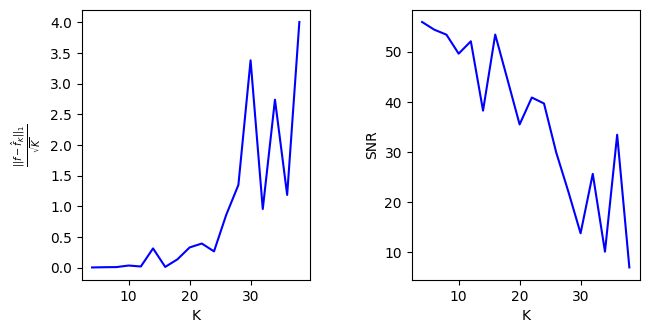

In [5]:
SNR_target = 50
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol, verbosity=0)[0]

Ks = np.arange(4, 40, 2).astype(int)
# Ms = np.round(30+Ks*np.log(np.exp(1)*N/Ks)).astype(int)
M=120
Q = 100 # Number of cores

n_trials = 5

errors = np.zeros((n_trials, len(Ks)))
SNRs = np.zeros( (n_trials, len(Ks)))

for j, K in enumerate(Ks):
    for n in range(n_trials):
        # M = Ms[j]

        print('(K,M, trial) = ({},{},{})'.format(K,M,n))

        f = np.zeros(N)
        f[np.random.permutation(np.arange(N))[:K]] = (-1)**(np.arange(K))
        pos_cores = np.random.permutation(np.arange(N))[:Q] # random cores locations
        a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)
        beta = np.zeros((M,N), dtype=complex)
        beta[:, pos_cores] = a_ij
        beta2 = corr_circ(np.conj(beta)) # autocorrelations of beta
        
        A_corr = Autocorr_model(beta2, wt=None)
        A_corr_r = Op2Real(A_corr)
        y_corr_r = A_corr_r@f
        f_hat = bpalg(A_corr_r, y_corr_r)

        errors[n,j] = np.linalg.norm(f-f_hat, 1)/np.sqrt(K)
        SNRs[n,j] = snr(f, f_hat)
        print(SNRs[n,j])

"Plot"
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.05, 0.05, 0.38, 0.9])
ax2 = fig.add_axes([0.6, 0.05, 0.38, 0.9])
ax1.plot(Ks, np.mean(errors,axis=0), 'b')
ax1.set_xlabel('K')
ax1.set_ylabel(r'$\frac{ ||f-\hat{f}_K||_1}{\sqrt{K}}$')
ax2.plot(Ks, np.mean(SNRs, axis=0), 'b')
ax2.set_xlabel('K')
ax2.set_ylabel('SNR')
plt.show()